# Batch Normalization in Tensorflow

### author: qhduan@memect.co

In [1]:
# 图表库
%matplotlib inline
import matplotlib.pyplot as plt
# 深度学习
import tensorflow as tf
# 矩阵
import numpy as np
# sklearn的各种辅助小工具
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer

In [2]:
# 设置随机种子，这样每次得到的随机数结果都一样了
tf.set_random_seed(0)

In [3]:
# 读取数据集
X, y = load_breast_cancer(return_X_y=True)

In [4]:
# 把目标变量改变形状，相当于把一个一维向量转化为一个1xn维矩阵（当然还是向量）
y = y.reshape([len(y), 1])

In [5]:
# one hot编码器，例如数据的分类数是3，可以吧把 0 编码为[0 0 1]，1 编码为 [0 1 0]， 2 编码为[1 0 0]
enc = OneHotEncoder()

In [6]:
y = enc.fit_transform(y).toarray()

In [7]:
# 分割测试集与训练集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [8]:
# 训练集有120条数据，测试集30条数据，输入有4个变量，输出有3个变量（多分类）
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(455, 30) (114, 30) (455, 2) (114, 2)


In [9]:
normalizer = Normalizer()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_train)

In [10]:
# 输入变量数
input_size = X_train.shape[1]
print('input_size is {}'.format(input_size))
# 输出变量数
target_size = y_train.shape[1]
print('target_size is {}'.format(target_size))

input_size is 30
target_size is 2


In [11]:
# input的占位
X = tf.placeholder(tf.float32, [None, input_size])
y = tf.placeholder(tf.float32, [None, target_size])

In [12]:
# 要训练的参数
W = tf.Variable(tf.random_normal([input_size, target_size]), name='weight')
b = tf.Variable(tf.zeros([target_size]), name='bias')

In [13]:
# Batch Normalization 变量
W_bn = tf.Variable(tf.random_normal([input_size, target_size]), name='weight_bn')
scale = tf.Variable(tf.ones([target_size]), name='scale_bn')
beta = tf.Variable(tf.zeros([target_size]), name='beta_bn')

$pred = softmax(XW + b)$

X和W都是矩阵，b是向量

$pred$就是一般公式的$\hat{y}$

In [14]:
# 输出结果
pred = tf.nn.softmax(tf.add(tf.matmul(X, W), b))

Batch Noramlization 可以把某一层标准化，公式：

$\frac{\gamma(x-\mu)}{\sigma}+\beta$

In [15]:
# Batch Normalization 输出结果
z = tf.matmul(X, W_bn)
# 一个很小的数，避免可能的除0错
epsilon = 1e-08
# 计算mean和variance
batch_mean, batch_var = tf.nn.moments(z, [0])
pred_bn = tf.nn.softmax(
    tf.nn.batch_normalization(z, batch_mean, batch_var, beta, scale, epsilon)
)

In [16]:
# 定义损失函数，这个是标准softmax损失
cost = tf.reduce_mean(
    -tf.reduce_sum(y * tf.log(pred),
    reduction_indices=1)
)

In [17]:
# Batch Normalization 损失函数
cost_bn = tf.reduce_mean(
    -tf.reduce_sum(y * tf.log(pred_bn),
    reduction_indices=1)
)

In [18]:
# 学习率
learning_rate = 0.01
# 迭代次数
n_epoch = 2000

In [19]:
# 梯度下降算子
opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [20]:
# 梯度下降算子
opt_bn = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_bn)

In [21]:
# 初始化所有变量
init = tf.initialize_all_variables()

In [22]:
# disable GPU，关闭GPU支持
config = tf.ConfigProto(
    device_count = {'GPU': 0}
)

In [23]:
# 保存历史损失
costs = []
costs_bn = []
with tf.Session(config=config) as sess:
    sess.run(init)
    # 开始迭代
    for epoch in range(n_epoch + 1):
        # 反向传播，梯度下降
        sess.run(opt, feed_dict={X: X_train, y: y_train})
        # Batch Normalization 反向传播，梯度下降
        sess.run(opt_bn, feed_dict={X: X_train, y: y_train})
        # 计算损失
        c = sess.run(cost, feed_dict={X: X_train, y: y_train})
        # Batch Normalization 计算损失
        c_bn = sess.run(cost_bn, feed_dict={X: X_train, y: y_train})
        # 记录损失
        costs.append(c)
        costs_bn.append(c_bn)
        if epoch % 50 == 0:
            print('Epoch: {}, cost: {}, cost_bn: {}'.format(epoch, c, c_bn))

Epoch: 0, cost: 0.7950537800788879, cost_bn: 0.6822519302368164
Epoch: 50, cost: 0.7164947986602783, cost_bn: 0.5721328854560852
Epoch: 100, cost: 0.6871000528335571, cost_bn: 0.5029422044754028
Epoch: 150, cost: 0.6758583784103394, cost_bn: 0.45696133375167847
Epoch: 200, cost: 0.6712700128555298, cost_bn: 0.4246111214160919
Epoch: 250, cost: 0.6691638231277466, cost_bn: 0.40077075362205505
Epoch: 300, cost: 0.6680012345314026, cost_bn: 0.382541686296463
Epoch: 350, cost: 0.6672029495239258, cost_bn: 0.36815112829208374
Epoch: 400, cost: 0.6665470600128174, cost_bn: 0.35649627447128296
Epoch: 450, cost: 0.665947675704956, cost_bn: 0.3468337059020996
Epoch: 500, cost: 0.6653710603713989, cost_bn: 0.3386845588684082
Epoch: 550, cost: 0.6648041009902954, cost_bn: 0.33169636130332947
Epoch: 600, cost: 0.6642416715621948, cost_bn: 0.3256116509437561
Epoch: 650, cost: 0.6636817455291748, cost_bn: 0.32024961709976196
Epoch: 700, cost: 0.663123369216919, cost_bn: 0.3154727816581726
Epoch: 750

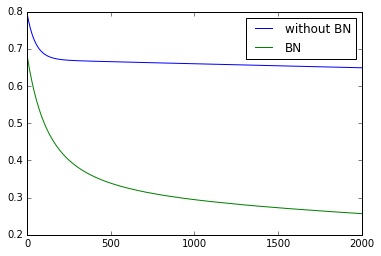

In [24]:
# 这张图是损失函数随着训练轮次增加而下降的图
plt.plot(list(range(len(costs))), costs)
plt.plot(list(range(len(costs))), costs_bn)
plt.legend(['without BN', 'BN'])

注意：Batch Normalization并不是万能药，可能在高维度大数据集上更有效，否则可能反效果